In [295]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import category_encoders as ce # импорт для работы с кодировщиком
import scipy.stats as stats

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


In [296]:
# df = pd.read_csv('clean_data.csv', index_col='created_time', parse_dates=['created_time'])
df = pd.read_csv('clean_data.csv')

In [297]:
# Подготовим данные для моделей импользуя кодировщик
encoder = ce.OneHotEncoder(cols=['sentiment'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['sentiment'])
df = pd.concat([df, type_bin], axis=1)

df

,comment_id,score,created_time,sentiment,sentiment_Positive,sentiment_Neutral,sentiment_Negative
0,1,1,2023-10-24 11:22:51,Positive,1,0,0
1,1,1,2023-10-24 11:22:03,Positive,1,0,0
2,1,1,2023-10-24 11:21:49,Positive,1,0,0
3,1,1,2023-10-24 11:21:41,Neutral,0,1,0
4,1,1,2023-10-24 11:21:27,Positive,1,0,0
...,...,...,...,...,...,...,...
338947,1,42,2023-10-07 05:20:11,Neutral,0,1,0
338948,1,1,2023-10-07 05:17:23,Neutral,0,1,0
338949,1,54,2023-10-07 05:08:26,Neutral,0,1,0
338950,1,116,2023-10-07 01:46:05,Negative,0,0,1


In [298]:
#  добавляем признаки на разбивкам по отношению
df['score_Positive'] = (df['score']*  df['sentiment_Positive']) + (df['comment_id'] *  df['sentiment_Positive'])
df['score_Neutral'] = (df['score']*  df['sentiment_Neutral']) + (df['comment_id'] *  df['sentiment_Neutral'])
df['score_Negative'] = (df['score']*  df['sentiment_Negative']) + (df['comment_id'] *  df['sentiment_Negative'])
df

,comment_id,score,created_time,sentiment,sentiment_Positive,sentiment_Neutral,sentiment_Negative,score_Positive,score_Neutral,score_Negative
0,1,1,2023-10-24 11:22:51,Positive,1,0,0,2,0,0
1,1,1,2023-10-24 11:22:03,Positive,1,0,0,2,0,0
2,1,1,2023-10-24 11:21:49,Positive,1,0,0,2,0,0
3,1,1,2023-10-24 11:21:41,Neutral,0,1,0,0,2,0
4,1,1,2023-10-24 11:21:27,Positive,1,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
338947,1,42,2023-10-07 05:20:11,Neutral,0,1,0,0,43,0
338948,1,1,2023-10-07 05:17:23,Neutral,0,1,0,0,2,0
338949,1,54,2023-10-07 05:08:26,Neutral,0,1,0,0,55,0
338950,1,116,2023-10-07 01:46:05,Negative,0,0,1,0,0,117


In [310]:
# обработает столбец время
df['created_time'] = pd.to_datetime(df['created_time'])
df['created_time'] = df['created_time'].dt.strftime('%Y-%m-%d %H')

In [311]:
df

,comment_id,score,created_time,sentiment,sentiment_Positive,sentiment_Neutral,sentiment_Negative,score_Positive,score_Neutral,score_Negative
0,1,1,2023-10-24 11,Positive,1,0,0,2,0,0
1,1,1,2023-10-24 11,Positive,1,0,0,2,0,0
2,1,1,2023-10-24 11,Positive,1,0,0,2,0,0
3,1,1,2023-10-24 11,Neutral,0,1,0,0,2,0
4,1,1,2023-10-24 11,Positive,1,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
338947,1,42,2023-10-07 05,Neutral,0,1,0,0,43,0
338948,1,1,2023-10-07 05,Neutral,0,1,0,0,2,0
338949,1,54,2023-10-07 05,Neutral,0,1,0,0,55,0
338950,1,116,2023-10-07 01,Negative,0,0,1,0,0,117


In [312]:
# так же обновим таблицу и сгруппируем по часам
df_summed = df.groupby('created_time').sum().reset_index()
df_summed['created_time'] = pd.to_datetime(df_summed['created_time'])


C:\Users\Psa1kl\AppData\Local\Temp\ipykernel_18316\4014031290.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_summed = df.groupby('created_time').sum().reset_index()


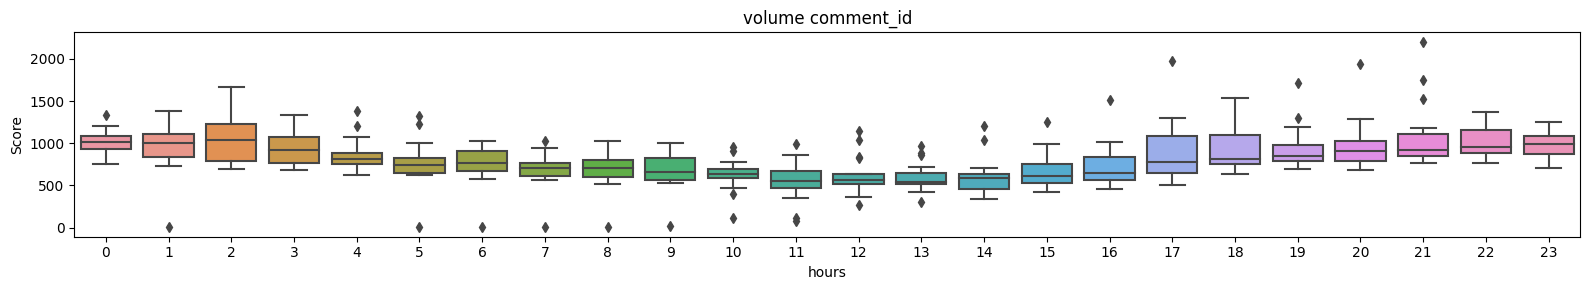

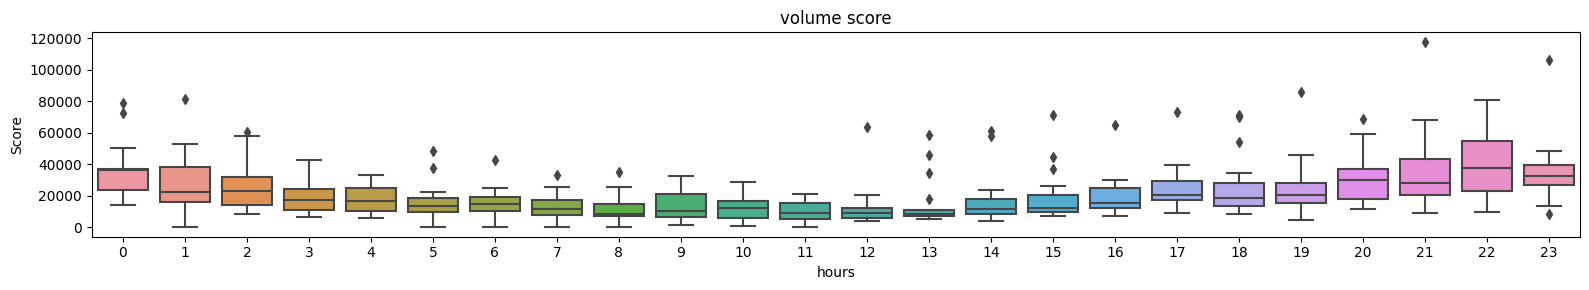

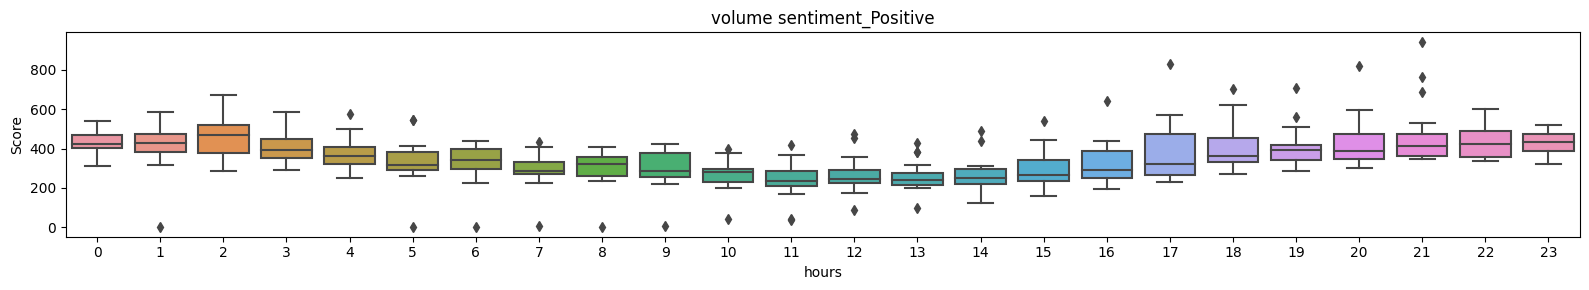

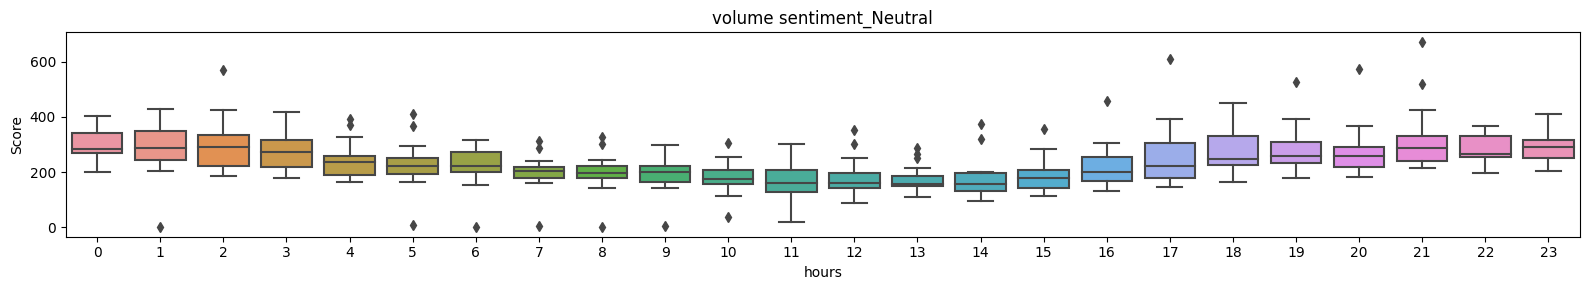

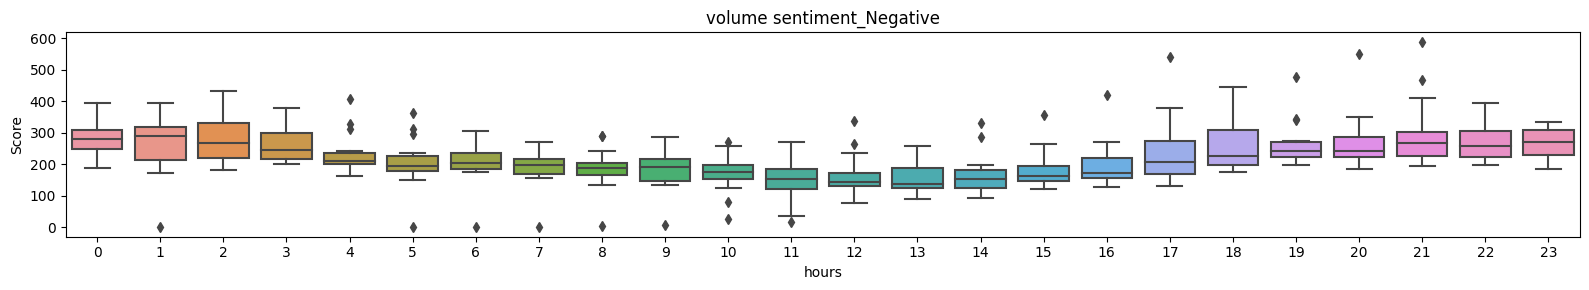

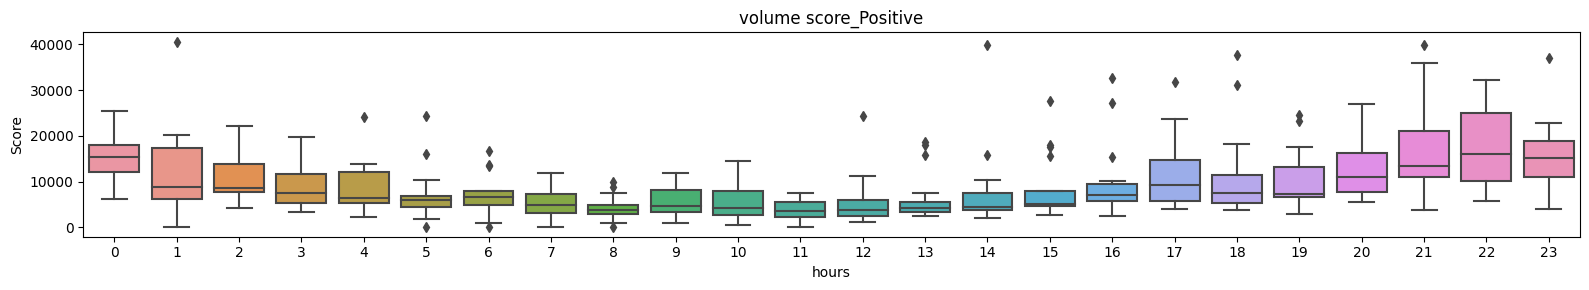

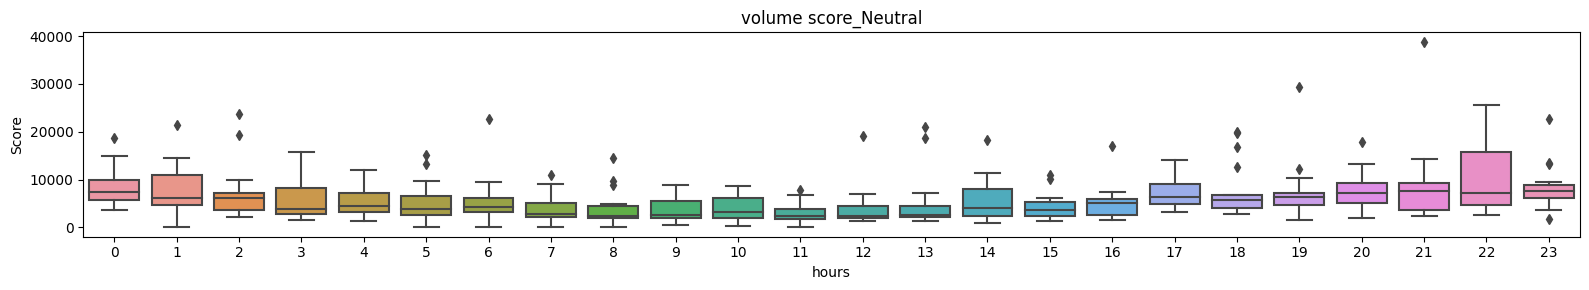

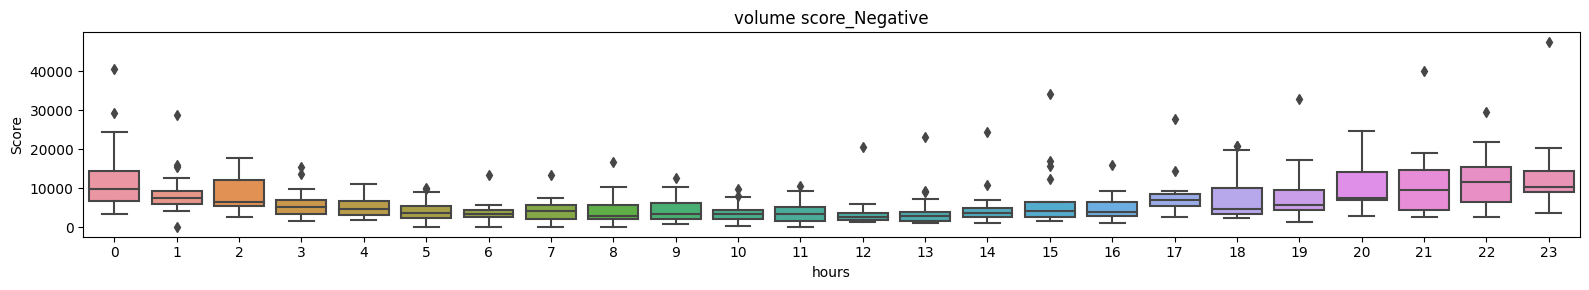

In [313]:
# Визуализируем объём самих комментариев по часам в сутках, а так же и лайков
for column in df_summed.columns[1:]:    
    ax = plt.subplots(figsize=(16, 3))
    sns.boxplot(x=df_summed.created_time.dt.hour, y=df_summed[column])
    plt.title(f'volume {column}')
    plt.xlabel('hours')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()

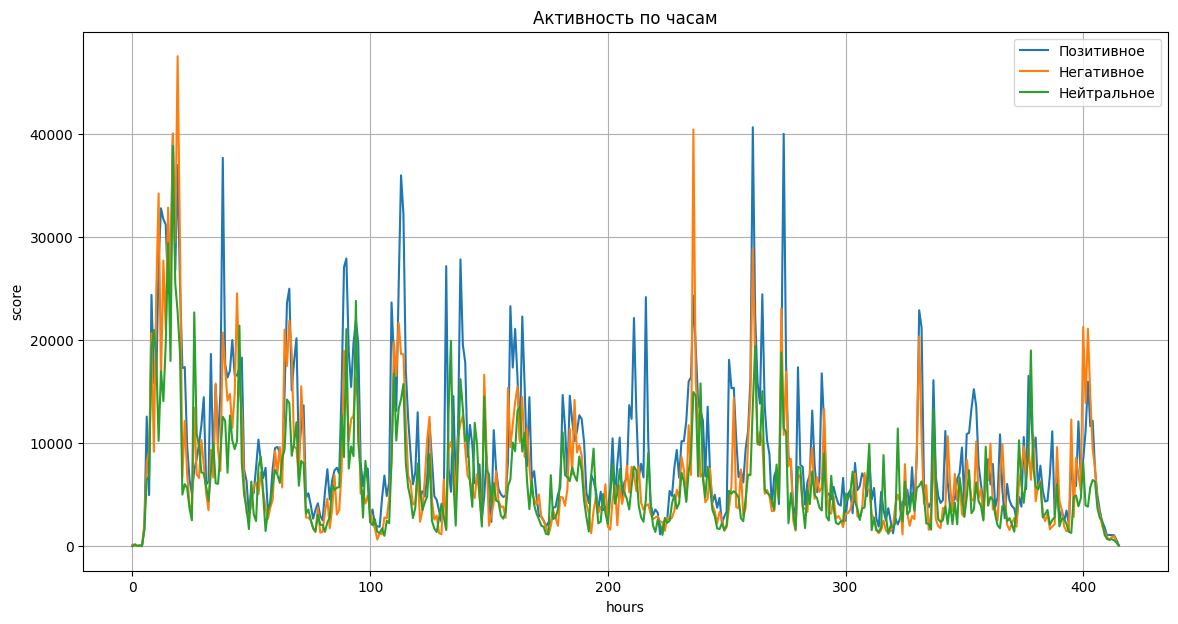

In [314]:
# Визуалищация по готовой таблице
plt.figure(figsize=(14, 7))  
plt.plot(df_summed['score_Positive'], label='Позитивное')
plt.plot(df_summed['score_Negative'], label='Негативное')
plt.plot(df_summed['score_Neutral'], label='Нейтральное')
plt.title('Активность по часам')
plt.xlabel('hours')
plt.ylabel('score')
plt.legend(loc='best') 
plt.grid(True)
plt.show()

Как мы видим, в целом лайки в позитивных комментариях преобладают над негативными, за исключением в первые часы конфликта, так как это были самые жестокие действия в конфликте.

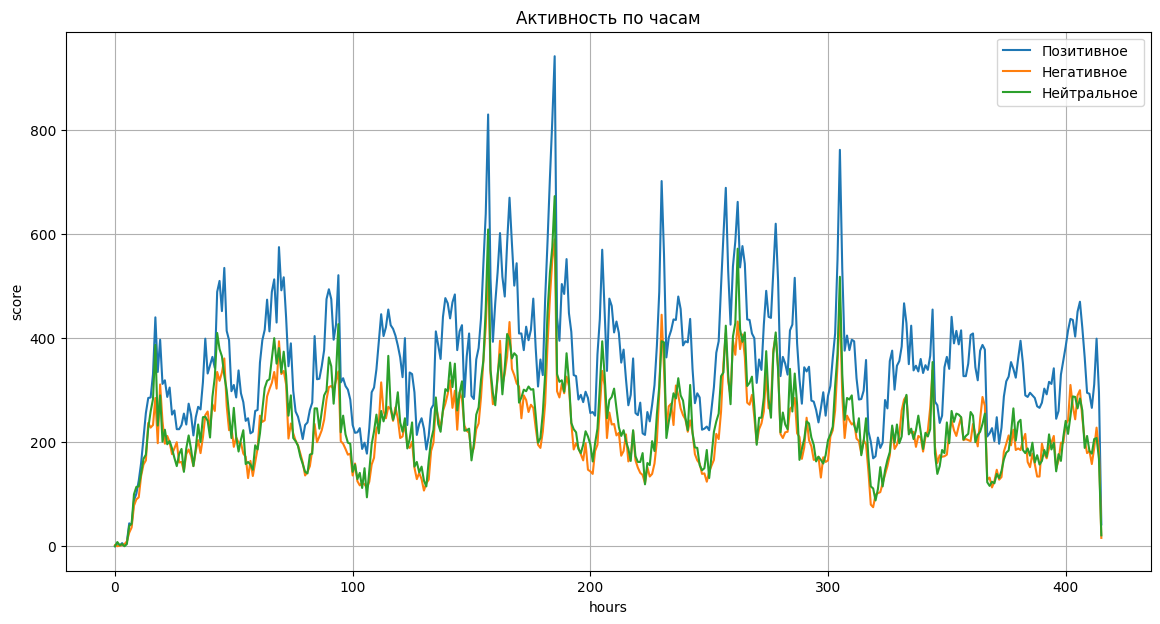

In [315]:
# Визуалищация по готовой таблице
plt.figure(figsize=(14, 7)) 
plt.plot(df_summed['sentiment_Positive'], label='Позитивное')
plt.plot(df_summed['sentiment_Negative'], label='Негативное')
plt.plot(df_summed['sentiment_Neutral'], label='Нейтральное')
plt.title('Активность по часам')
plt.xlabel('hours')
plt.ylabel('score')
plt.legend(loc='best') 
plt.grid(True)
plt.show()

Если говорить по только по комментариям, то тут по всему временному ряду преобладают позитивные.

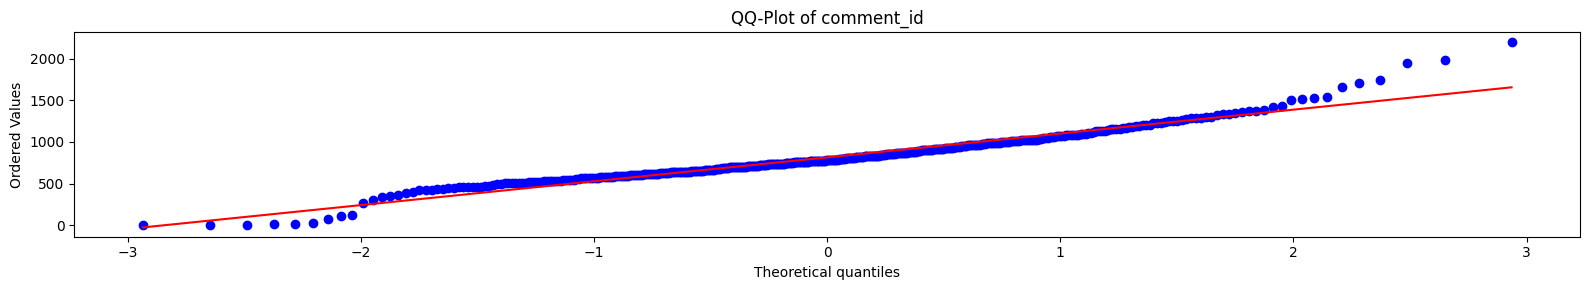

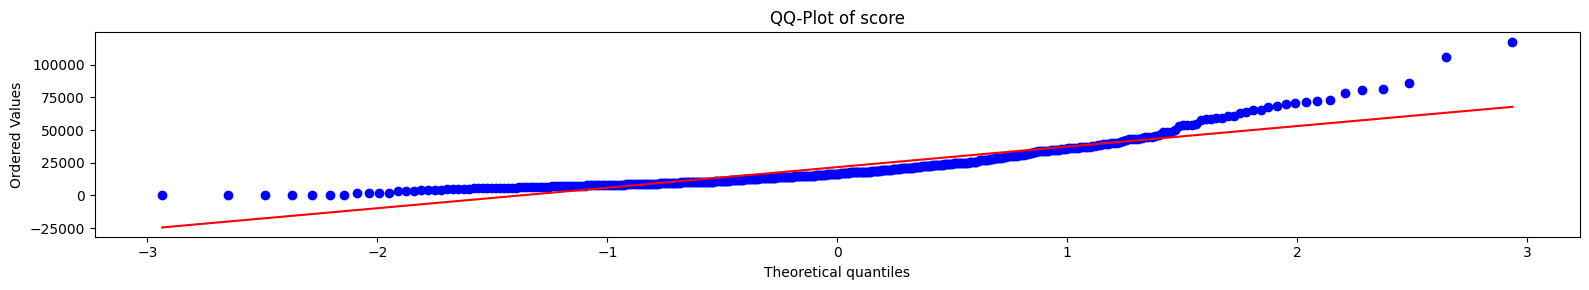

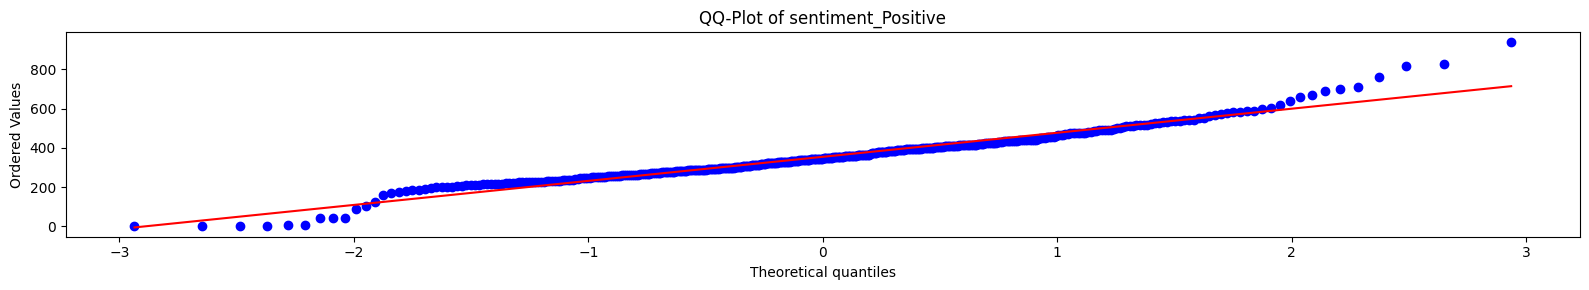

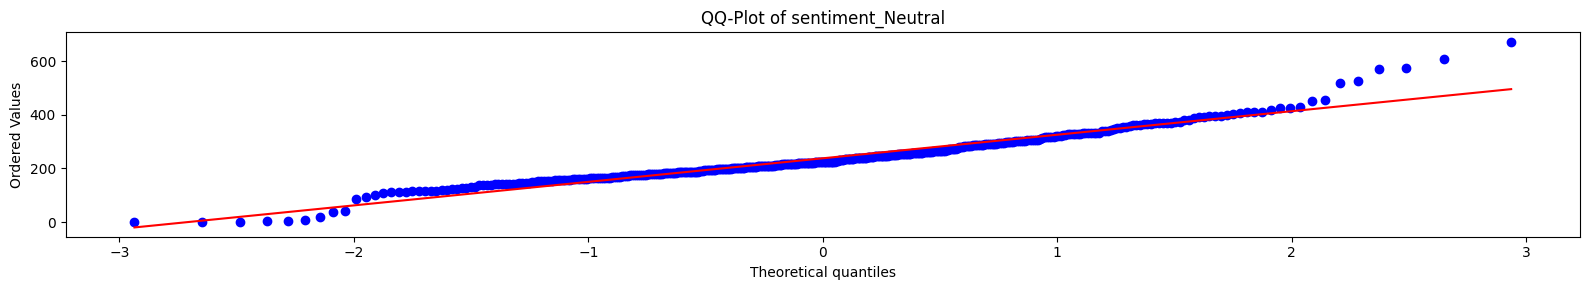

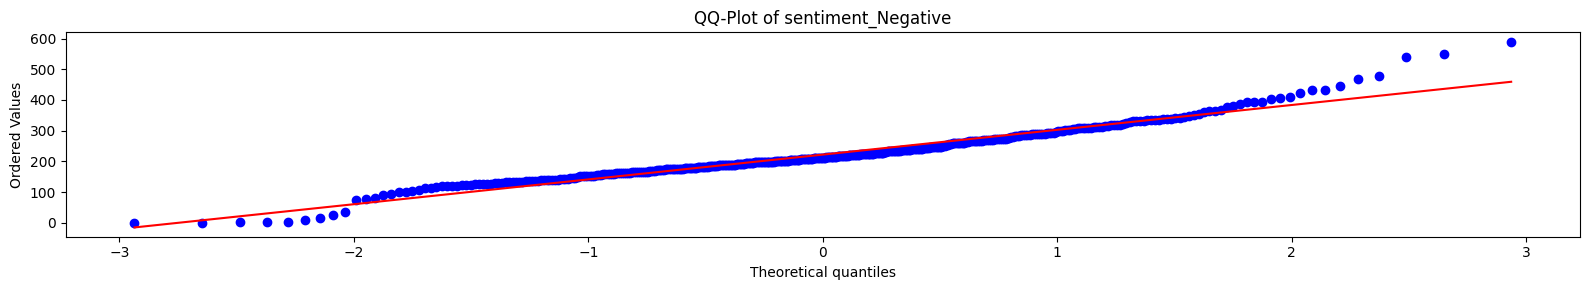

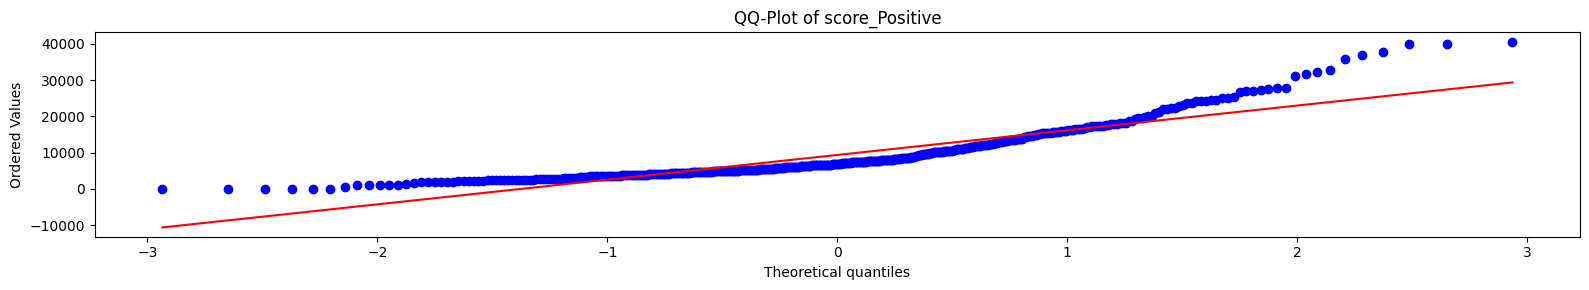

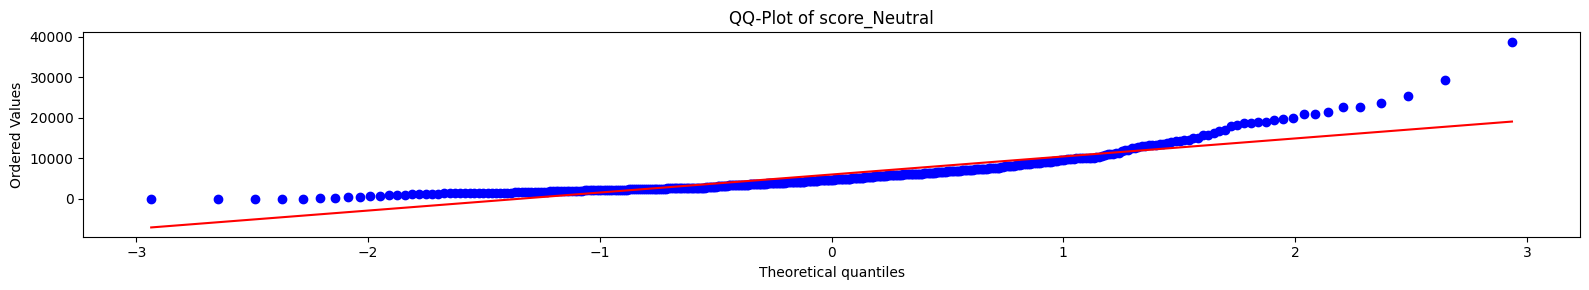

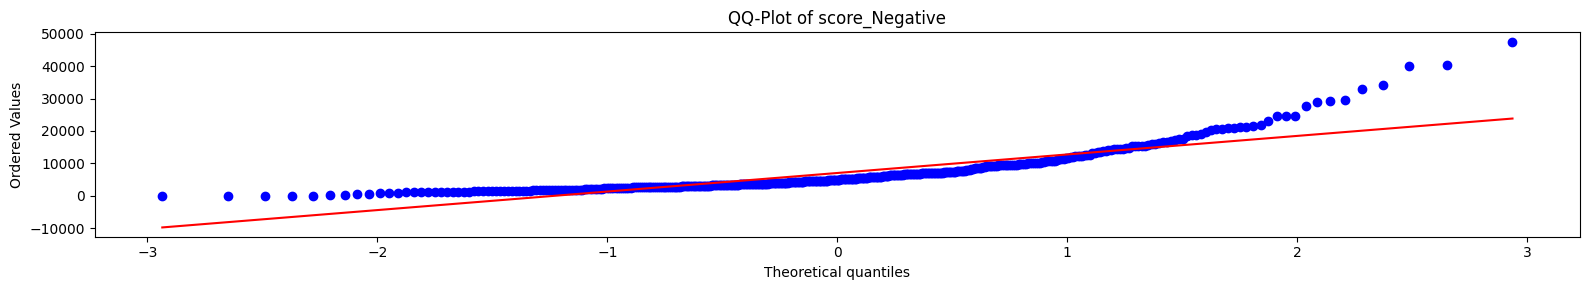

In [316]:
# Построим графики распределения(QQ-Plot)
for column in df_summed.columns[1:]:
    plt.figure(figsize=(16, 3))
    stats.probplot(df_summed[column], dist="norm", plot=plt)
    plt.title(f'QQ-Plot of {column}')
    plt.tight_layout()
    plt.show()

Распределения комментраиев по всем графикам отличаются от нормального

In [321]:
# посмотрим на итоги по предъобработке данных
df_summed

,created_time,comment_id,score,sentiment_Positive,sentiment_Neutral,sentiment_Negative,score_Positive,score_Neutral,score_Negative
0,2023-10-07 01:00:00,2,146,0,0,2,0,0,148
1,2023-10-07 05:00:00,10,213,2,8,0,42,181,0
2,2023-10-07 06:00:00,4,30,1,2,1,13,18,3
3,2023-10-07 07:00:00,12,119,6,4,2,71,65,-5
4,2023-10-07 08:00:00,5,21,1,0,4,-13,0,39
...,...,...,...,...,...,...,...,...,...
411,2023-10-24 07:00:00,602,1685,266,178,158,1081,601,605
412,2023-10-24 08:00:00,706,1892,311,206,189,1061,677,860
413,2023-10-24 09:00:00,835,1747,399,208,228,1057,560,965
414,2023-10-24 10:00:00,648,701,296,168,184,602,353,394


In [318]:
#Создадим фунцию для сохранения файлов к обчучающей модели
def df_model_to_csv(df, col1, col2, file_name):

    new_df = df[[col1, col2]]
    new_df = new_df.loc[new_df[col2] != 0]
    new_df.to_csv(f"{file_name}.csv", index=False)

    print(f"File '{file_name}.csv' has been saved successfully.")
    return None


In [319]:
#для примера возьмем сохраним файл по  общему объёму позитивных комментариев
df_model_to_csv(df_summed,'created_time', 'score_Positive', 'pos_vol')

File 'pos_vol.csv' has been saved successfully.
